# A Differentiable Approximation for Entropies 

We'll be using Tensorflow:

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [4]:
sess = tf.InteractiveSession()

## Entropy and Information Content in Neural Networks

Neural networks are just functions. Admittedly, highly parameterized functions, but yes - just functions: $y=f(x)$. Here, $x$ is some input - like e.g. an image - and $y$ is the output. Once the network is sufficiently trained, we dare to interpret the output as an estimation for the probability of that image to represent a particular digit, given the pixel intensities of that image. Even humans would agree that the following digit may be interpreted in different ways. You may in fact give it a 10% probability to be a three. Typically, we even dare to interpret the highest of probabilities as the *prediction*, like "That image in fact *is* a digit 5".

![3_or_5](./5.png)

Training a neural network means exposing the network to a sufficiently large sample (the training set) from a probability distribution of pixel sets (images) and guide it (via Gradient Descent) to reproduce (infer) the digit that was meant by the hand-writing (the prior). In information theory, we call *"writing the digit down and making a photo of it"* a noisy encoding. The information about the original intent is still encoded in the image, but sometimes there's room for misinterpretations. Now, as the pixel distribution is passed through the neural network, at each layer we create a new a new distribution - this time of activations - from the original input. It would be interesting to understand how the information content changes from layer to layer. And that's where Entropy enters the game. 

Aurelion Geron recorded an amazingly easy-to-grasp youtube clip called [Entropy, Cross-Entropy, & KL-Divergence](https://www.youtube.com/watch?v=ErfnhcEV1O8). If you're not already familiar with the concepts of entropy, I highly recommend it. Aurelion's warm-hearted french accent makes information theory even sound somewhat sexy. Here's a summary of things you should know and understand to some degree:

##### Entropy 

$ H(X) := -\sum_{x \in \mathcal{X}} p(x) \log p(x)$

##### Conditional entropy 

$ H(Y \big| X) := \sum_{x \in \mathcal{X}} p(x) H(Y\big|X=x) = \sum_{x \in \mathcal{X}} p(x) \sum_{y\in \mathcal{Y}} p(y|x) \cdot \log p(y|x) = \sum_{x \in \mathcal{X}} \sum_{y\in \mathcal{Y}} p(x,y) \log(\frac{p(x,y)}{p(x)})$

##### Joint Entropy 

$ H(Y, X) := -\sum_{x \in \mathcal{X}} \sum_{y\in \mathcal{Y}} p(x,y) \log p(x,y)$

##### Mutual information

$ I(X;Y) := \sum_{x \in \mathcal{X}} \sum_{y\in \mathcal{Y}} p(x,y)log(\frac{p(x,y)}{p(x)p(y)}) $

##### Some useful properties 
1. $H(X,Y) \leq H(X)+H(Y)$
1. $H(Y|X) = 0 \iff$ Y is completely determined by X 
1. $H(Y|X) = H(Y) \iff $ X and Y are independent
1. $H(Y|X) = H(Y,X) - H(X)$
1. $I(X;Y) = H(X) + H(Y) - H(X,Y)$

## Interlude: Differentiable Partitioning

We have seen how we can calculate the total entropy and the conditional entropy with regards to the labels of a mini-batch of image samples with the help of simple statistics based on binned distributions. In order to use the entropy as a cost function within the concept of gradient-based optimization, we need a differentiable approximation of the entropy terms. That turns out to be an easy exercise. 

Remember the sigmoid function?
$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Let's use it to create a more interesting kind of *partitioning* function:

$$ f(x) = \sigma(x - x_l) \cdot \sigma(x + x_r) $$

For example, for $x_l=5$ and $x_r=15$, that function looks like

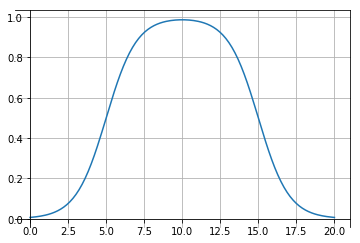

In [5]:
def f(x, x_l, x_r):
    return sigmoid(x - x_l) * sigmoid(-x + x_r)
x=np.linspace(0, 20, 200)
fig, ax = plt.subplots()
ax.plot(x, f(x, 5, 15))
ax.grid(True, which='both')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

See, what it does? It approximately maps all values in a certain bin's range to 1 and all values outside of it to 0. 

To make this function more square-looking and treat the borders appropriate, we introduce stretch and margin parameters. You'll easily figure out yourself what they do.

Here's the precise definition that we'll use in the following calucations

Let $ x_i \in [x_{min}, x_{max}] $ be a sample from distribution $D$, $d=x_{max}-x_{min}$,
let $\alpha, \epsilon$ be arbitrary real numbers representing a stretch and a margin, then we define the *bin filter* $\beta_n(x)$ for the $n$-th bin of width $d$ as

$$ \beta_n(x_i) = \sigma(\alpha \cdot (x_i - l_n) + \epsilon) \cdot 
 \sigma(\alpha \cdot ( -x_i + l_n + d + \epsilon))
$$

Here, $l_n$ is the left border of the $n$-th bin: $l_n = x_{min} + (n-1) \cdot d$ 

In [6]:
def beta(n, N, l, r, alpha=5.0, epsilon=1.0):
    """
    return the bin function for the n-th bin of N bins for numbers between l and r
    alpha and epsilon are stretch and margin parameters
    """
    d = (r - l) / N
    l_n = l + (n-1) * d
    def _beta(x):
        return tf.nn.sigmoid(alpha * (x-l_n+epsilon)) * \
    tf.nn.sigmoid(alpha*(-x+l_n+d+epsilon))
    
    return _beta

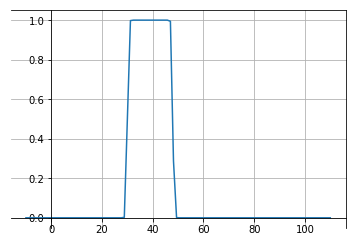

In [9]:
x=np.linspace(-10, 110, 100)
fig, ax = plt.subplots()
beta2=beta(2, 5, 15, 95, 5.0, 1)
beta2_x = sess.run(beta2(x))
ax.plot(x, beta2_x)
ax.grid(True, which='both')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

This function has the nice property that it is differentiable and that it provides an excellent way to approximate a bin-distribution. Let's look at the following example distribution. Think of these numbers as the values of a single activation for some small mini-batch. 

In [112]:
# This could be a pixel's or a single activation's distribution over a minibatch
D=tf.constant(
    [3,2,5,4,7,5,4,8,6,4,6,7,4,6,3,4,6,7,4,3,5,6,1,2,9,7,2,1,9,7,3,1], 
    dtype=tf.float32)*10+5

# And these could be the corresponding labels. Note the strong correlation!
L=tf.constant(
    [0,0,1,1,1,0,1,2,0,1,0,2,0,1,0,1,1,1,0,0,1,1,0,0,2,2,0,0,2,1,0,0], 
    dtype=tf.float32)

In [104]:
sess.run(D)

array([35., 25., 55., 45., 75., 55., 45., 85., 65., 45., 65., 75., 45.,
       65., 35., 45., 65., 75., 45., 35., 55., 65., 15., 25., 95., 75.,
       25., 15., 95., 75., 35., 15.], dtype=float32)

Let's put them into 5 bins, like we did for the entropy statistics. Note that, of course, the choice of 5 is arbitrary, so consider this a hyper-parameter. In fact, varying this parameter within reasonable bounds shouldn't have any noteworthy impact on the results. Feel free to check it for yourself

(array([ 6., 10.,  3., 10.,  3.]),
 array([15., 31., 47., 63., 79., 95.]),
 <a list of 5 Patch objects>)

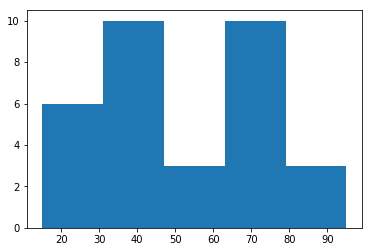

In [105]:
_D = sess.run(D)
plt.hist(_D, bins=5)

Now, we create the 5 functions $\beta_1(x_i)$ to $\beta_5(x_i)$ 

In [106]:
betas=[beta(n+1, 5, 15, 95, 5.0, 1) for n in range(5)]

And have a look at what these $\beta_k(x_i)$ look like. Don't get confused by the following code. The array index is zero-based. ```betas[2]``` is therefore the third *bin filter* function.

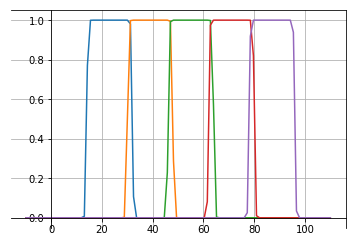

In [107]:
beta1, beta2, beta3, beta4, beta5 = sess.run([betas[k](x) for k in range(5)])

x=np.linspace(-10, 110, 100)
fig, ax = plt.subplots()
ax.plot(x, beta1)
ax.plot(x, beta2)
ax.plot(x, beta3)
ax.plot(x, beta4)
ax.plot(x, beta5)
ax.grid(True, which='both')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

Let's use these functions to count the number of values $x_i$ that fall into a particular bin, and that in a differentiable manner! 
Obviously, in any real-life scenario, we'd have to tune the strech and margin hyper-parameters to avoid double counting. Here, I chose the values within $D$ just so that the boundary problem doesn't show up.

Let $c_k$ the number of values in bin $k$, $M$ be the number of samples. Think of $M$ as the size of a mini-batch. 

Then, the functions $\beta_k$ approximately *count* the number of values that fall into their non-zero range.

$$ \sum_{i=1}^M \beta_k(x_i) \approx c_k$$

Don't believe me? Good - you shouldn't. Rather see for yourself:

In [108]:
sess.run([tf.reduce_sum(betas[n](D)) for n in range(5)])

[5.979923, 9.999998, 3.0736217, 9.999998, 2.9866161]

Compare that to the bin counts of the histogram above. Easy exercise. I promised. No magic. What's cool, is that we can now approximate the various entropies of the pixel or activation distributions within each mini-batch in a differentiable manner and do some experiments.

The Entropy of a distribution X was defined as

$$ H(X) := -\sum_{x \in \mathcal{X}} p(x) \log p(x)$$

Using the bin counts $c_k$ with $\sum c_k = M$ as shown above, we get

$$ H(X) = -\sum_{k=1}^N  \frac{c_k}{M} \log  \frac{c_k}{M}$$

With our differentiable approximation the conditional entropy can be approximated by

$$ \tilde{H}(X) = \log M -\frac{1}{M}\sum_{k=1}^N  \sum_{i=1}^M \beta_k(x_i)  \log  \sum_{i=1}^M \beta_k(x_i) $$



In [58]:
def entropy(D, N, alpha = 5.0, epsilon = 1.0):
    """
    Calculate the entropy of discrete sample D using N bins 
    """
    d_max=tf.reduce_max(D)
    d_min=tf.reduce_min(D)
    M = tf.cast(tf.size(D), dtype=tf.float32)
    
    filters=[beta(n+1, N, d_max, d_min, alpha, epsilon) for n in range(N)]
    c=[tf.reduce_sum(filters[k](D)) for k in range(N)] # this is summing over i
    sums = tf.reduce_sum(c * tf.log(c)) 
    return tf.log(M) - sums / M

Note, that in the above implementation, we didn't supply lower and upper bounds so the counts may slightly differ from the previous calculations. In a scenario with a bigger range of values, that will not matter much. In the end, we know we're approximating the entropy anyway.

In [109]:
sess.run(entropy(D, 5))

3.465736

Now, the conditional entropy goes just the same way, only that we need to mask the classes out after counting the samples in each bin. Masking is obviously done with the help of the labels that usually come with the training samples.

Remember how we calculate the conditional entropy?

$$ H(Y \big| X) = \sum_{x \in \mathcal{X}} \sum_{y\in \mathcal{Y}} p(x,y) \log(\frac{p(x,y)}{p(x)})$$

The implementation is pretty straight-forward

In [94]:
def cond_entropy(D, L, N_classes, N_bins=5, alpha=5.0, epsilon=1.0):
    """
        calculate the conditional entropy of distribution D given class labels L
    """
    epsilon_stab = 1e-4
    d_max=tf.reduce_max(D)
    d_min=tf.reduce_min(D)
    M=tf.cast(tf.size(L), dtype=tf.float32)

    betas=[beta(n+1, N_bins, d_min, d_max, alpha, epsilon) for n in range(N_bins)]

    # mask[i] has 1 only for class i - 0 otherwise
    mask=[tf.cast(tf.equal(L,k),tf.float32) 
          for k in range(N_classes)]

    # three lists of counts = three conditional distributions
    cond_counts = [[tf.reduce_sum(betas[n](D)*mask[k]) 
                    for n in range(N_bins)] for k in range(N_classes)]

    pxy = cond_counts / M # p(x,y)

    px = tf.reduce_sum(cond_counts, axis=1) / M # p(x)

    # need to transpose forth and back to enable broadcasting
    pxy_px = tf.transpose(tf.transpose(pxy) / (tf.transpose(px)) + epsilon_stab) # stabilized log term

    return -tf.reduce_sum(pxy * tf.log(pxy_px))


In [110]:
sess.run(cond_entropy(D, L, 3))

1.0423439

Just as expected, the conditional entropy is significantly lower than the entropy of the original distribution without knowledge of the prior distribution. We obviously expect this because we chose the distribution D strongly correlated.
Now we intend to train a network to minimize the conditional entropy while maintaining the given entropy of the signal.

In [129]:
D = _D // 10
D

array([3., 2., 5., 4., 7., 5., 4., 8., 6., 4., 6., 7., 4., 6., 3., 4., 6.,
       7., 4., 3., 5., 6., 1., 2., 9., 7., 2., 1., 9., 7., 3., 1.],
      dtype=float32)

In [130]:
for j in range(10):
    p = np.random.permutation(10)
    p_map={k: p[k] for k in range(10)}
    Dp=[p_map[d] for d in D]
    print(Dp)


[1, 0, 3, 2, 8, 3, 2, 9, 4, 2, 4, 8, 2, 4, 1, 2, 4, 8, 2, 1, 3, 4, 7, 0, 5, 8, 0, 7, 5, 8, 1, 7]
[6, 0, 9, 5, 2, 9, 5, 3, 1, 5, 1, 2, 5, 1, 6, 5, 1, 2, 5, 6, 9, 1, 7, 0, 8, 2, 0, 7, 8, 2, 6, 7]
[9, 7, 0, 6, 1, 0, 6, 4, 2, 6, 2, 1, 6, 2, 9, 6, 2, 1, 6, 9, 0, 2, 8, 7, 3, 1, 7, 8, 3, 1, 9, 8]
[0, 2, 4, 9, 1, 4, 9, 5, 8, 9, 8, 1, 9, 8, 0, 9, 8, 1, 9, 0, 4, 8, 6, 2, 3, 1, 2, 6, 3, 1, 0, 6]
[2, 8, 3, 7, 9, 3, 7, 6, 0, 7, 0, 9, 7, 0, 2, 7, 0, 9, 7, 2, 3, 0, 4, 8, 5, 9, 8, 4, 5, 9, 2, 4]
[3, 9, 6, 0, 7, 6, 0, 5, 8, 0, 8, 7, 0, 8, 3, 0, 8, 7, 0, 3, 6, 8, 1, 9, 4, 7, 9, 1, 4, 7, 3, 1]
[3, 9, 5, 2, 4, 5, 2, 0, 1, 2, 1, 4, 2, 1, 3, 2, 1, 4, 2, 3, 5, 1, 7, 9, 8, 4, 9, 7, 8, 4, 3, 7]
[5, 6, 2, 8, 3, 2, 8, 7, 9, 8, 9, 3, 8, 9, 5, 8, 9, 3, 8, 5, 2, 9, 0, 6, 4, 3, 6, 0, 4, 3, 5, 0]
[3, 5, 4, 1, 7, 4, 1, 6, 8, 1, 8, 7, 1, 8, 3, 1, 8, 7, 1, 3, 4, 8, 0, 5, 2, 7, 5, 0, 2, 7, 3, 0]
[8, 4, 2, 1, 7, 2, 1, 5, 6, 1, 6, 7, 1, 6, 8, 1, 6, 7, 1, 8, 2, 6, 0, 4, 9, 7, 4, 0, 9, 7, 8, 0]
